# Load .ODO files

qulaity controlled by Claire
save as NetCDF file

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import pandas as pd
import os
import gsw
from pathlib import Path
import re
import statistics

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = Path('data/BioGeoChem/') 

moor = 'rteb1'

In [16]:
def load_moor_data(file,moor,year):
    def __dms2dd(degrees, minutes, direction):
        dd = float(degrees) + float(minutes)/60;
        if direction == 'W' or direction == 'S':
            dd *= -1
        return dd;
    
    def __depth_func(value_chosen,moor):

        minimum = float("inf")
        setted_list = [50, 75, 100, 250, 500, 750, 755, 950, 1000, 1250, 1500, 1600, 1775]
        #setted_list = [750, 950, 1600]
        for val in setted_list:
            if abs(val - value_chosen) < minimum:
               final_value = float(val)
               minimum = abs(val - value_chosen)
        return final_value

    def __read_header(file,moor):

        with open(file) as myfile:
            head = [next(myfile) for x in range(10)]
            attr_str={}
            coord_str={}
            for line in head:
                info = re.split('[ \n]+',line)
                if info[0]=='Latitude' or info[0]=='Longitude':
                    attr_str[info[0]] = __dms2dd(info[2],info[3],info[4])
                elif info[0]=='InstrDepth':
                    if str(file)[-26:]=='rteb1_04_2017_007.microcat' or str(file)[-26:]=='rteb1_05_2018_006.microcat':
                        coord_str['depth'] = ('depth',[float(755)])
                    else:
                        coord_str['depth'] = ('depth',[__depth_func(float(info[2]),moor)])
                else:
                    attr_str[info[0]] = info[2]
            attr_str['Latitude_units'] = 'degrees_north'
            attr_str['Longitude_units'] = 'degrees_east'
        return attr_str,coord_str
    
    def __load_csv_as_xr(file,moor):
        attr_str = __read_header(file,moor)
        cols = ['yyyy', 'mm', 'dd', 'hh', 'temp', 'cond', 'pres', 'oxy']
        df = pd.read_csv(file, sep='\s+' ,parse_dates={'dates': [0,1,2,3]}, squeeze=True, 
                         header = None, skiprows = 11, names = cols, engine='python')

        for idx,dt in enumerate(df['dates']):
            date_str =dt[:4]+dt[5:7]+dt[8:10]
            df['dates'][idx]=(pd.to_datetime(date_str,format='%Y%m%d')+datetime.timedelta(hours=np.float(dt[11:])))

        ds = xr.Dataset.from_dataframe(df)
        attr_str,coord_str = __read_header(file,moor)
        ds.coords['time']=ds.dates
        ds = ds.swap_dims({'index':'time'}).drop('index').drop_vars('dates')
        ds.attrs = attr_str
        ds = ds.expand_dims('depth')
        ds = ds.assign_coords(coord_str)
        ds['sal'] = gsw.SP_from_C(ds.cond, ds.temp, ds.pres)
        ds = ds.drop_vars('cond')
        return ds

#     def __get_filelist(data_path,moor,year):
#         file_list = list(sorted(
#             (data_path).glob(f"{moor}_ODO/{moor}_??_{year}*.ODO")
#             ))
#         return file_list

#     files = __get_filelist(data_path,moor,year)
    ds = __load_csv_as_xr(file,moor)
#     for file in files[1:]:
#         ds = xr.concat([ds,__load_csv_as_xr(file,moor)],dim='time')
    
    ds.depth.attrs['units']='m'
    
    ds.temp.attrs['standard_name'] = "sea_water_temperature" ;
    ds.temp.attrs['long_name'] = "In Situ Temperature of Sea Water" ;
    ds.temp.attrs['units'] = "degree_C" ;
    
    ds.sal.attrs['standard_name'] = "sea_water_salinity" ;
    ds.sal.attrs['long_name'] = "Practical Salinity on the PSS-78 scale" ;
    ds.sal.attrs['units'] = "unitless" ;
    
    ds.pres.attrs['standard_name'] = 'sea_water_pressure'
    ds.pres.attrs['long_name'] = 'Pressure of Sea Water'
    ds.pres.attrs['units'] = 'dbar'
    
    ds.oxy.attrs['standard_name'] = 'sea_water_oxygen_concentration'
    ds.oxy.attrs['long_name'] = 'Oxygen Concentration of Sea Water'
    ds.oxy.attrs['units'] = 'µmol/kg'     
    
    ds.attrs['Mooring'] = f'{moor}'
    del ds.attrs['SerialNumber']
    
    
#     setted_list = [50, 75, 100, 250, 500, 750, 755, 950, 1000, 1250, 1500, 1600, 1775]
#     #setted_list = [750, 950, 1600] 
#     for val in setted_list:
#         if val not in ds.depth:
#             dummy = ds.isel(depth=1)
#             dummy['depth'] = val
#             for var in ds.var(): dummy[var] = dummy[var]*np.nan
#             ds = xr.concat([ds,dummy],dim='depth')
    
    return ds

In [17]:
def get_filelist(data_path,moor,year):
    file_list = list(sorted(
        (data_path).glob(f"{moor}_ODO/{moor}_??_{year}*.ODO")
        ))
    return file_list

In [18]:
file = get_filelist(data_path,moor,2017)

In [28]:
ds = load_moor_data(file[0],moor,2017)
ds = ds.resample(time = "2h").mean(keep_attrs=True);
ds1 = load_moor_data(file[1],moor,2017)
ds1 = ds1.resample(time = "2h").mean(keep_attrs=True);
ds2 = load_moor_data(file[2],moor,2017)
ds2 = ds2.resample(time = "2h").mean(keep_attrs=True);



In [33]:
ds = xr.concat([ds,ds1,ds2],dim='depth')

In [35]:
ds

<xarray.Dataset>
Dimensions:  (depth: 3, time: 5038)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-13T12:00:00 ... 2018-07-07T06:00:00
  * depth    (depth) float64 750.0 950.0 1.6e+03
Data variables:
    temp     (time, depth) float64 8.783 7.551 4.159 8.927 ... 8.743 7.882 4.252
    pres     (time, depth) float64 765.9 966.4 1.62e+03 ... 957.3 1.618e+03
    oxy      (time, depth) float64 236.5 220.6 260.8 238.9 ... 258.2 nan 262.0
    sal      (time, depth) float64 35.26 35.23 34.96 35.27 ... 35.24 35.2 34.97
Attributes:
    Mooring:          rteb1
    WaterDepth:       1800
    Start_Date:       2017/05/13
    Start_Time:       12:31
    End_Date:         2018/07/07
    End_Time:         07:15
    Latitude:         57.1005
    Longitude:        -9.563833333333333
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

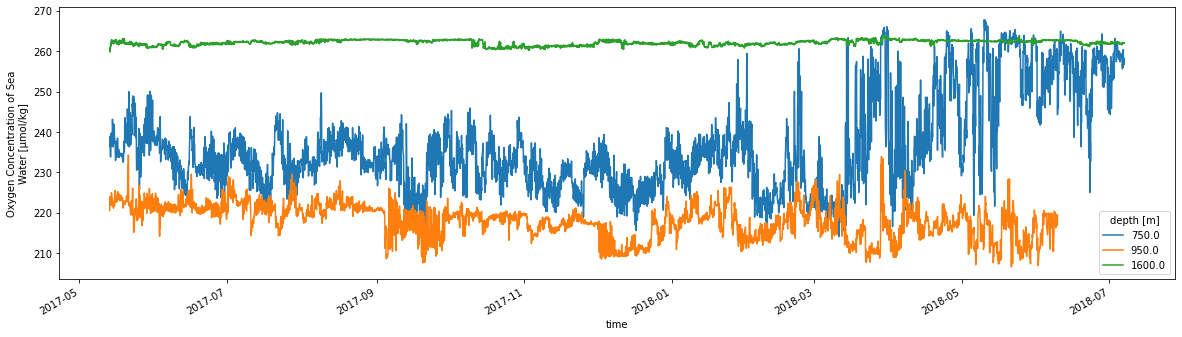

In [36]:
ds.oxy.plot.line(x='time', figsize = (20,5));


In [37]:
ds_eb_ox = ds.drop_vars(['temp','sal'])

In [38]:
ds_eb_ox

<xarray.Dataset>
Dimensions:  (depth: 3, time: 5038)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-13T12:00:00 ... 2018-07-07T06:00:00
  * depth    (depth) float64 750.0 950.0 1.6e+03
Data variables:
    pres     (time, depth) float64 765.9 966.4 1.62e+03 ... 957.3 1.618e+03
    oxy      (time, depth) float64 236.5 220.6 260.8 238.9 ... 258.2 nan 262.0
Attributes:
    Mooring:          rteb1
    WaterDepth:       1800
    Start_Date:       2017/05/13
    Start_Time:       12:31
    End_Date:         2018/07/07
    End_Time:         07:15
    Latitude:         57.1005
    Longitude:        -9.563833333333333
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

In [39]:
ds1D = ds_eb_ox.resample(time = "1D").mean(keep_attrs=True)

In [41]:
ds1D.to_netcdf(f'data/{moor}_oxy_1D.nc', 
         engine='netcdf4',
        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})